In [1]:
cd ..

/home/mashraf/GCNs_for_WDS


In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import torch
# torch.set_default_dtype(torch.float64) 
# torch.backends.cudnn.allow_tf32 = False
# torch.backends.cuda.matmul.allow_tf32 = False
import os, datetime
import numpy as np
from utils.utils import create_graph, WDN_Graph, plot_errors, plot_graph, plot_timeseries, normalize_hydraulics, denormalize_hydraulics
from models.models import *
from train_test import train, test
import argparse, json, pickle
import wandb
from collections import defaultdict
import warnings
import matplotlib.pyplot as plt
import pandas as pd
warnings.filterwarnings('ignore')
CUDA_LAUNCH_BLOCKING=1

In [7]:
wdss = ['anytown', 'hanoi', 'pescara', 'area_c', 'zhijiang', 'modena', 'pa1', 'balerma', 'area_a', 'l_town', 'kl']
wds_names = ['Anytown', 'Hanoi', 'Pescara', 'Area C', 'Zhi Jiang', 'Modena', 'PA1', 'Balerma', 'Area A', 'L-Town', 'KL']


models = ['SPI_GNN']
_type = 'demands'

cmbnd_maes, cmbnd_mae_stds = np.zeros((len(wdss)*2, 10)), np.zeros((len(wdss)*2, 10))
m = 0
for model in models:
    for w, wds in enumerate(wdss):
        if model == 'PI_GNN' and wds in ['area_a', 'kl']:
            continue
        else:
            if _type == 'demands':
                csv_path = os.path.join(os.getcwd(), "results_ijcnn", model, "robustness", "robustness_"+wds+"_"+model+"_[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ].csv")
            elif _type == 'diameters':
                csv_path = os.path.join(os.getcwd(), "results_ijcnn", model, "robustness", "robustness_"+wds+"_"+model+"_[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ].csv")

            robust_df = pd.read_csv(csv_path).T
            robust_df.columns = robust_df.iloc[0]
            robust_df = robust_df.drop(robust_df.index[0]).astype('float32')

            sigmas = robust_df["sigma"].values * 10
            cmbnd_mae = (robust_df["h_mae"].values + robust_df["d_tilde_mae"].values + robust_df["q_tilde_mae"].values) / 3
            # cmbnd_mae_std = (robust_df["h_mae_std"].values + robust_df["d_tilde_mae_std"].values + robust_df["q_tilde_mae_std"].values) / 3

            cmbnd_maes[w+m, :] = cmbnd_mae
    m+=len(wdss)


[0.224 0.447 0.548 0.742 1.   ]


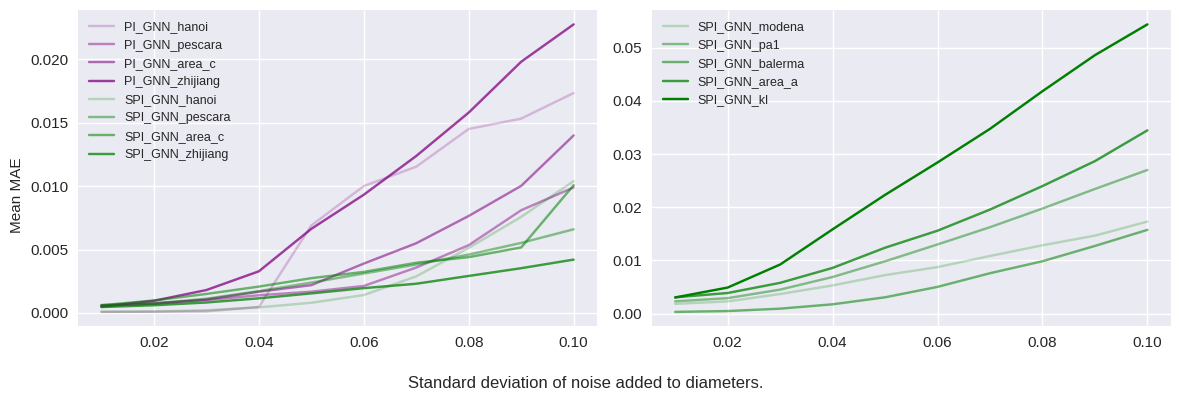

In [94]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["font.family"] = "Times New Roman"

plt.style.use('seaborn-v0_8')

weights = np.power([.05, .2, .3, .55, 1.], .5) #- 1
print(weights)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, tight_layout=True)

for idx in range(len(wdss)-5):
    ax[0].plot(sigmas, cmbnd_maes[idx], label=models[0]+"_"+wdss[idx], color='purple', alpha=weights[idx])
ax[0].tick_params(labelsize=11)

for idx in range(len(wdss)-5):
    ax[0].plot(sigmas, cmbnd_maes[idx+len(wdss)], label=models[1]+"_"+wdss[idx], color='green', alpha=weights[idx])
ax[0].tick_params(labelsize=11)
ax[0].legend(fontsize=9, loc='upper left')


# for idx in range(4,len(wdss)-2):
#     ax[1].plot(sigmas, cmbnd_maes[idx], label=models[0]+"_"+wdss[idx], color='purple', alpha=weights[idx-4])
# ax[1].tick_params(labelsize=11)

for idx in range(4,len(wdss)):
    ax[1].plot(sigmas, cmbnd_maes[idx+len(wdss)], label=models[1]+"_"+wdss[idx], color='green', alpha=weights[idx-4])
ax[1].tick_params(labelsize=11)
ax[1].legend(fontsize=9, loc='upper left')


fig.supxlabel('Standard deviation of noise added to '+_type+'.', size=12)
fig.supylabel('Mean MAE', size=11)
# fig.suptitle('Robustness of SPI_GNN to change in '+_type+'.', size=12)
fig.savefig(os.path.join(os.getcwd(), 'results_ijcnn', 'robustness_plot_'+_type+'.jpg'), dpi=300)
# plt.close()


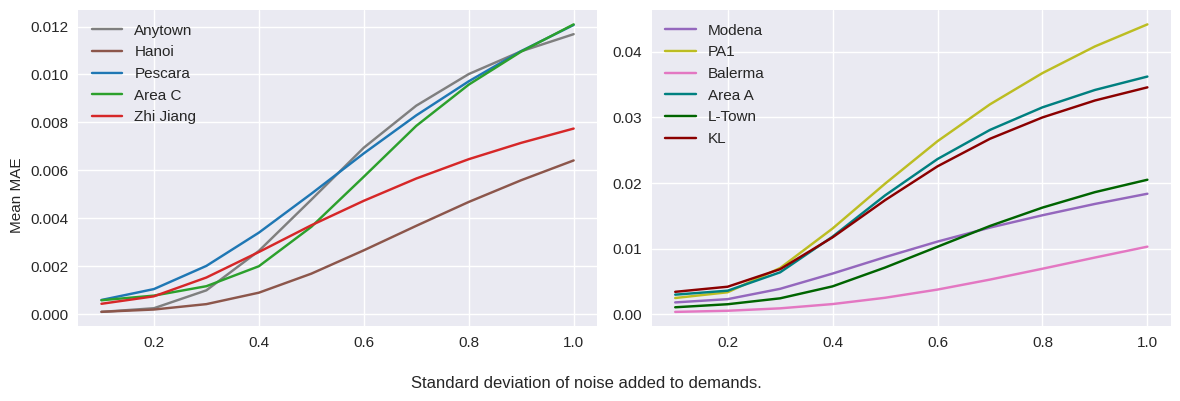

In [8]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["font.family"] = "Times New Roman"

plt.style.use('seaborn-v0_8')

colors = ['tab:gray', 'tab:brown', 'tab:blue', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive', 'tab:pink', 'teal', 'darkgreen', 'darkred']

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, tight_layout=True)

for idx in range(len(wdss)-6):
    ax[0].plot(sigmas, cmbnd_maes[idx], label=wds_names[idx], color=colors[idx])
ax[0].tick_params(labelsize=11)
ax[0].legend(fontsize=11, loc='upper left')


for idx in range(5,len(wdss)):
    ax[1].plot(sigmas, cmbnd_maes[idx], label=wds_names[idx], color=colors[idx])
ax[1].tick_params(labelsize=11)
ax[1].legend(fontsize=11, loc='upper left')

fig.supxlabel('Standard deviation of noise added to '+_type+'.', size=12)
fig.supylabel('Mean MAE', size=11)
# fig.suptitle('Robustness of SPI_GNN to change in '+_type+'.', size=12)
fig.savefig(os.path.join(os.getcwd(), 'results_ijcnn', 'robustness_plot_'+_type+'.jpg'), dpi=300)
# plt.close()


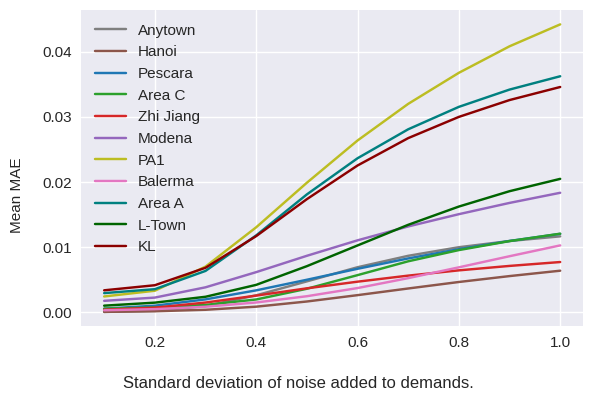

In [9]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["font.family"] = "Times New Roman"

plt.style.use('seaborn-v0_8')

fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharex=True, tight_layout=True)

for idx in range(len(wdss)):
    ax.plot(sigmas, cmbnd_maes[idx], label=wds_names[idx], color=colors[idx])
ax.tick_params(labelsize=11)
ax.legend(fontsize=11, loc='upper left')

fig.supxlabel('Standard deviation of noise added to '+_type+'.', size=12)
fig.supylabel('Mean MAE', size=11)
# fig.suptitle('Robustness of SPI_GNN to change in '+_type+'.', size=12)
fig.savefig(os.path.join(os.getcwd(), 'results_ijcnn', 'robustness_plot_'+_type+'_single.jpg'), dpi=300)
# plt.close()
